In [158]:
balance_names = []

In [159]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk
tf.random.set_seed(42)

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [160]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [196]:
reduction = 1

img_width = int(500/reduction)
img_height = int(600/reduction)

In [197]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [198]:
random.shuffle(image_names)

In [199]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [200]:
def convert_to_baw(img, thresh=80):
    fn = lambda x: 255 if x > thresh else 0
    return img.convert('L').point(fn, mode='1')

In [201]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.7), int(len(image_names)*0.9)])

In [202]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        #img = convert_to_baw(img)
        #img = img.crop((120, 0, 160, 600))
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    #img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    #img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 240.13it/s]


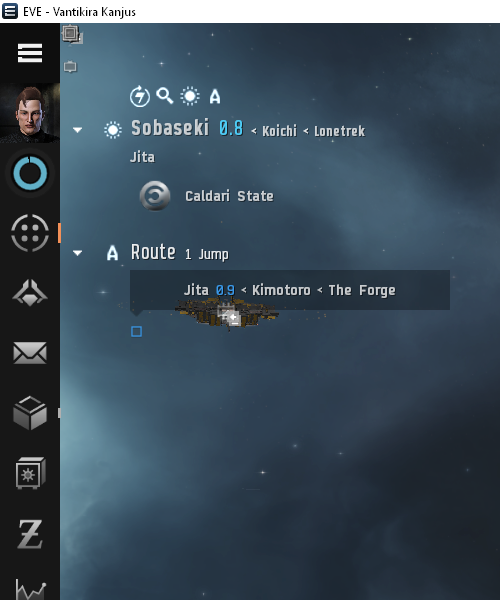

In [203]:
Image.fromarray(train_x[0])

In [204]:
train_x[0].shape

(600, 500, 3)

In [205]:
np.array([[1]*9]*2).shape

(2, 9)

In [206]:
len(train_x)

1217

In [207]:
train_x[0].shape

(600, 500, 3)

In [208]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name][0] / reduction)
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name][0] / reduction)
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name][0] / reduction)

100%|████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<?, ?it/s]


In [209]:
len(train_x)

1217

In [210]:
train_x[0].shape

(600, 500, 3)

In [211]:
len(train_y)

1217

In [212]:
train_y[0]

334.0

In [213]:
augmentations = 0
aug_range_y = [-50, 60]

#balance_names = []

train_alter_x = []
train_alter_y = []
train_alter_names = []
for i in tqdm(range(len(train_x))):
    true_aug = augmentations
    if train_names[i] in balance_names:
        true_aug = augmentations * (balance_names.count(train_names[i]))
        
    for a in range(true_aug):
        img = Image.fromarray(train_x[i])
        x_pixels = 0  
        y_pixels = random.randint(*aug_range_y)
        translated_img = img.transform(img.size, Image.AFFINE, (1, 0, x_pixels, 0, 1, y_pixels))
        train_alter_x.append(np.array(translated_img))

        train_alter_y.append(train_y[i] - y_pixels)
        train_alter_names.append(train_names[i])

train_x = train_x + train_alter_x
train_y = train_y + train_alter_y
train_names = np.array(list(train_names) + train_alter_names)

100%|█████████████████████████████████████████████████████████████████████████| 1217/1217 [00:00<00:00, 1214771.05it/s]


257.0


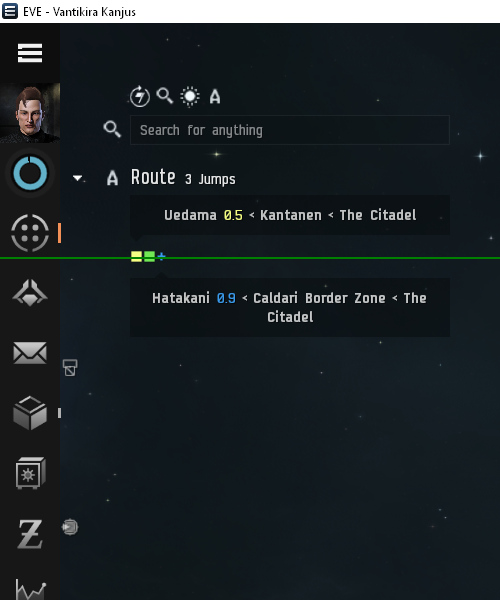

In [214]:
index = 1000
img = Image.fromarray(train_x[index])
img1 = ImageDraw.Draw(img)  
y = train_y[index]
print(y)
img1.line([(0, y),(500, y)], fill ="Green", width=2)
img

207.0


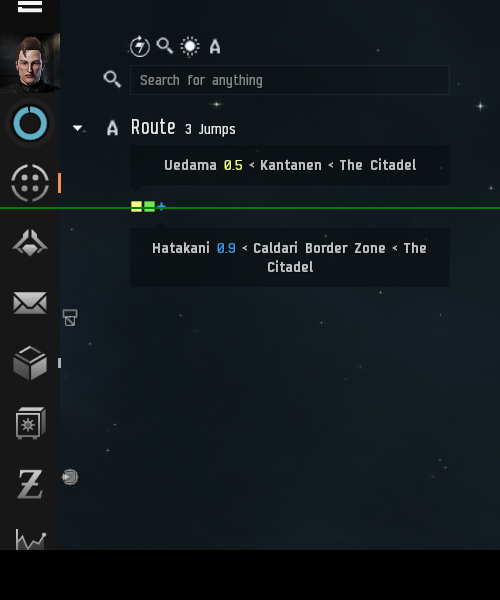

In [215]:
x_pixels=0
y_pixels=50
index = 1000
img = Image.fromarray(train_x[index])
img = img.transform(img.size, Image.AFFINE, (1, 0, x_pixels, 0, 1, y_pixels))
img1 = ImageDraw.Draw(img)  
y = train_y[index] - y_pixels
print(y)
img1.line([(0, y),(500, y)], fill ="Green", width=2)
img



In [216]:
train_y[0]

334.0

In [217]:
train_y[-1]

348.0

In [218]:
len(train_x)

1217

In [219]:
train_x[0].shape

(600, 500, 3)

In [220]:
len(train_y)

1217

In [221]:
len(train_alter_y)

0

In [222]:
import pandas as pd

In [223]:
data = { 'image_names':train_names, 'y':train_y
}
df = pd.DataFrame(columns=['image_names','y'], data=data)
df

,image_names,y
0,31c34c3b-d4d4-11ed-beab-2cf05d9fe8eb.png,334.0
1,de868296-d4d0-11ed-bb91-2cf05d9fe8eb.png,409.0
2,c2a8b7a5-d40a-11ed-bd74-2cf05d9fe8eb.png,485.0
3,fa7a1e27-d4d1-11ed-837e-2cf05d9fe8eb.png,293.0
4,362a6da0-d343-11ed-a5f4-2cf05d9fe8eb.png,296.0
...,...,...
1212,feba0a45-d4cf-11ed-85fc-2cf05d9fe8eb.png,344.0
1213,fc153cc2-d4d3-11ed-bd16-2cf05d9fe8eb.png,295.0
1214,71ea278b-d4cf-11ed-87d1-2cf05d9fe8eb.png,465.0
1215,3ad58cfd-d343-11ed-8692-2cf05d9fe8eb.png,257.0


In [226]:
df['bins'] = pd.cut(df['y'], bins=range(0,600,11))
df

,image_names,y,bins
0,31c34c3b-d4d4-11ed-beab-2cf05d9fe8eb.png,334.0,"(330, 341]"
1,de868296-d4d0-11ed-bb91-2cf05d9fe8eb.png,409.0,"(407, 418]"
2,c2a8b7a5-d40a-11ed-bd74-2cf05d9fe8eb.png,485.0,"(484, 495]"
3,fa7a1e27-d4d1-11ed-837e-2cf05d9fe8eb.png,293.0,"(286, 297]"
4,362a6da0-d343-11ed-a5f4-2cf05d9fe8eb.png,296.0,"(286, 297]"
...,...,...,...
1212,feba0a45-d4cf-11ed-85fc-2cf05d9fe8eb.png,344.0,"(341, 352]"
1213,fc153cc2-d4d3-11ed-bd16-2cf05d9fe8eb.png,295.0,"(286, 297]"
1214,71ea278b-d4cf-11ed-87d1-2cf05d9fe8eb.png,465.0,"(462, 473]"
1215,3ad58cfd-d343-11ed-8692-2cf05d9fe8eb.png,257.0,"(253, 264]"


In [227]:
df['bin_id'] = 0
for i in df.index:
    df.loc[i, 'bin_id'] = df.loc[i, 'bins'].left
df['tick'] = 1

df.groupby('bin_id')['tick'].sum().sort_values(ascending=True)

bin_id
495      2
275      3
473      4
363      6
242      7
264      8
429     10
308     10
220     12
319     22
209     22
297     25
440     26
396     28
352     32
484     41
418     41
407     74
330     91
462    102
374    116
198    119
286    122
253    124
341    170
Name: tick, dtype: int64

In [237]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise
        
def copy(source, destination):
    with open(source, 'rb') as file:
        myFile = file.read()
    with open(destination, 'wb') as file:
        file.write(myFile)

In [236]:
import os, os.path
path = r'O:\eve_models\training_data\route_y_large_vert_class'
unique_bins = df['bin_id'].unique()
for bin_id in unique_bins:
    mkdir_p(f"{path}\\{bin_id}")

In [238]:
source = r'O:\eve_models\training_data\route_y'
dest = r'O:\eve_models\training_data\route_y_large_vert_class'
for i in df.index:
    this_source = f"{source}\\{df.loc[i, 'image_names']}"
    this_dest = f"{dest}\\{df.loc[i, 'bin_id']}\\{df.loc[i, 'image_names']}"
    copy(this_source, this_dest)

In [228]:
index = df.groupby('bin_id')['tick'].sum().sort_values(ascending=True)[0:10].index
index

Int64Index([495, 275, 473, 363, 242, 264, 429, 308, 220, 319], dtype='int64', name='bin_id')

In [229]:
low_image_names = list(df.loc[df['bin_id'].isin(list(index))]['image_names'].values)
len(low_image_names)

84

In [230]:
new_box = []
for i, record in enumerate(image_data_raw):
    if record['image_name'] not in low_image_names:
        new_box.append(record)
print(len(image_data_raw))
print(len(new_box))

f = open(f"{path}\\boxesv2.json", "w")
f.write(json.dumps(new_box, indent=1))
f.close()

1739
1655


277.0


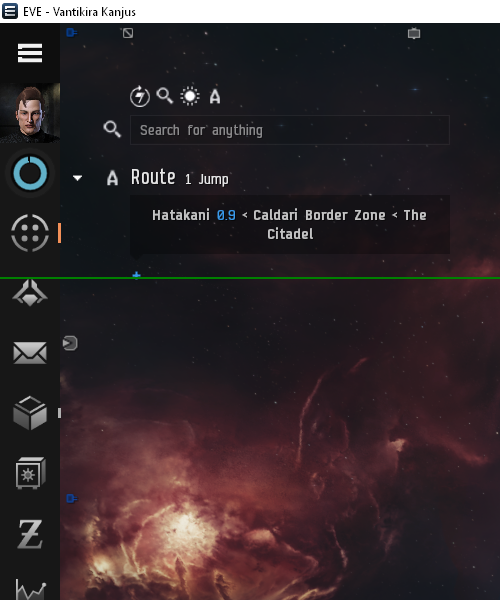

In [232]:


index = df[df['bin_id'] == 275].index[0]
img = Image.fromarray(train_x[index])
img1 = ImageDraw.Draw(img)  
y = train_y[index]
print(y)
img1.line([(0, y),(500, y)], fill ="Green", width=2)
img

In [31]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y) / np.array([300])
val_y = np.array(val_y) / np.array([300])
test_y = np.array(test_y) / np.array([300])

#train_y = np.array(train_y)
#val_y = np.array(val_y)
#test_y = np.array(test_y)

In [32]:
train_y[0]

0.6966666666666667

In [33]:
train_y[-1]

0.57

In [34]:
train_x[30].shape

(300, 250, 3)

<Axes: ylabel='Count'>

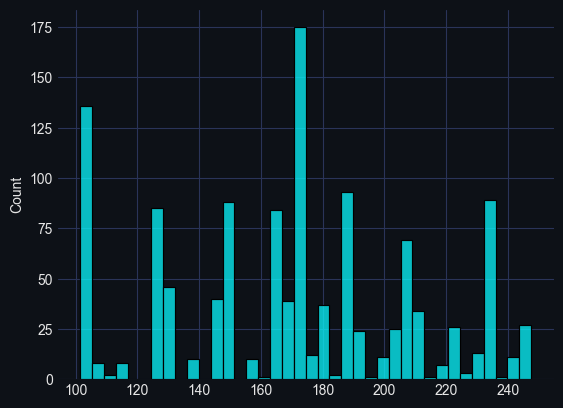

In [67]:
import seaborn as sns
sns.histplot(train_y, bins=38)

In [35]:
len(train_x)

37758

In [36]:
# measures of dispersion
min_ = np.amin(train_y)
max_ = np.amax(train_y)
range_ = np.ptp(train_y)
variance = np.var(train_y)
sd = np.std(train_y)
 
#print("Array =", train_y)
print("Measures of Dispersion")
print("Minimum =", min_)
print("Maximum =", max_)
print("Range =", range_)
print("Variance =", variance)
print("Standard Deviation =", sd)

Measures of Dispersion
Minimum = 0.14166666666666666
Maximum = 0.995
Range = 0.8533333333333333
Variance = 0.029208619561940957
Standard Deviation = 0.17090529413081668


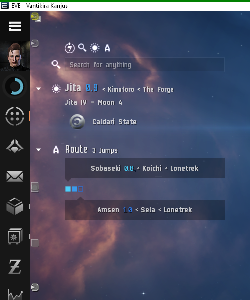

In [37]:
index = 1217
#img = Image.open(f"{path}\\{train_names[index]}")
img = Image.fromarray(train_x[index])
#truth = (train_y[index] * np.array([600])) # reduction
truth = (train_y[index]) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth),(500,truth)], fill ="Green", width=2)
img

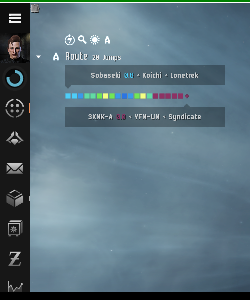

In [38]:
index = 1218
#img = Image.open(f"{path}\\{train_names[index]}")
img = Image.fromarray(train_x[index])
#truth = (train_y[index] * np.array([600])) # reduction
truth = (train_y[index]) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth),(500,truth)], fill ="Green", width=2)
img

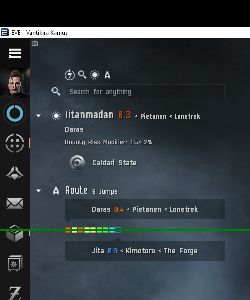

In [39]:
index = 12206
#img = Image.open(f"{path}\\{train_names[index]}")
img = Image.fromarray(train_x[index])
#truth = (train_y[index] * np.array([600])) # reduction
truth = (train_y[index]) * np.array(300) # reduction
img1 = ImageDraw.Draw(img)  
img1.line([(0,truth),(500,truth)], fill ="Green", width=2)
img

In [40]:
train_y[index]

0.765

In [41]:
config_meta = {'image_resize': [300, 250], 
               'class_location': 'O:\\eve_models\\training_data\\large_box_counter\\large_box_counter_classes.json', 
               'model_location': 'O:\\eve_models\\training_data\\large_box_counter\\large_box_counter_model.h5', 
               'class_names': ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']}
box_counter_model = tf.keras.models.load_model(config_meta['model_location'], compile=False)
config = json.load(open(config_meta['class_location']))
config

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [42]:
box_counter_model.layers

In [43]:
source_model = tf.keras.Model(box_counter_model.layers[0].input, box_counter_model.layers[7].output)
for source_layer in source_model.layers:
    source_model.trainable = False

In [44]:
#model.layers[1].output

In [45]:
model = Sequential([
    #layers.Input(shape=(img_height, img_width,3)),
    #layers.Rescaling(1. / 255, input_shape=(img_height, img_width,3)),
    source_model,
    layers.Flatten(),
    layers.Dense(units=32, activation="linear"),
    layers.Dense(units=1024, activation="selu"),
    layers.Dense(units=1, activation="linear", name='bounding_box')  
])


epochs = 500
lr = 1e-3

callbacks = [
    ReduceLROnPlateau(monitor='val_root_mean_squared_error', factor=0.5, patience=5, min_lr=1e-10, verbose=1),
    #lr_finder,
    EarlyStopping(monitor='val_root_mean_squared_error', patience=20, restore_best_weights=False),
]

#model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.mae, metrics=['accuracy', 'mse', 'mae'])
model.compile(optimizer=SGD(lr), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.losses.MeanSquaredError()])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=512,
    shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)



Epoch 1/500
74/74 [==============================] - 10s 101ms/step - loss: 0.1408 - root_mean_squared_error: 0.3753 - mean_squared_error: 0.1405 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2022 - val_mean_squared_error: 0.0409 - lr: 0.0010
Epoch 2/500
74/74 [==============================] - 6s 80ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755 - mean_squared_error: 0.0308 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322 - val_mean_squared_error: 0.0175 - lr: 0.0010
Epoch 3/500
74/74 [==============================] - 6s 82ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - mean_squared_error: 0.0201 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211 - val_mean_squared_error: 0.0147 - lr: 0.0010
Epoch 4/500
74/74 [==============================] - 6s 80ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - mean_squared_error: 0.0171 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138 - val_mean_squared_error: 0.0129 - lr: 0.0010
Epoch 5/50

KeyboardInterrupt: 

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
mplcyberpunk.make_lines_glow()

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

NameError: name 'history' is not defined

In [47]:
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
mplcyberpunk.make_lines_glow()

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

NameError: name 'history' is not defined

1/1 [==============================] - 0s 217ms/step
[91.62991047]
[104.]


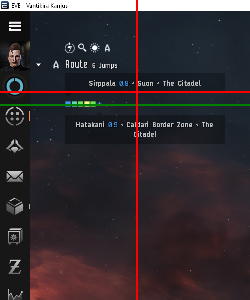

In [48]:
test_image_index = 50

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([300])) # reduction
result = result[0]
print(result)
truth = (test_y[test_image_index] * np.array([300])) # reduction
print(truth)

img = Image.fromarray(test_x[test_image_index]) 
#img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img

In [49]:
model.save('test_location.h5')

In [50]:
from tensorflow.keras import backend as K
predictions = model.predict(train_x)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
rmses = []
hunting_files = []
for i in tqdm(range(len(train_x))):
    
    rmse = root_mean_squared_error(train_y[i], predictions[i]).numpy()
    rmses.append(rmse)
    hunting_files.append(train_names[i])


am = np.argmax(rmses)
print(f"argmax {am}")
test_image_index = am
print(f"Worst RMSE:{rmses[test_image_index]}")

prediction = model.predict(np.array([train_x[test_image_index]]))
result = ((prediction) * np.array([300])) # reduction
result = result[0]
print(result)
truth = (train_y[test_image_index] * np.array([300])) # reduction
print(truth)

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.fromarray(train_x[test_image_index])
#img = Image.open(f'O:\\eve_models\\training_data\\route_y\\{hunting_files[am]}')
img1 = ImageDraw.Draw(img)  
#img1.ellipse((result[0]-10,result[1]-10,result[0]+10,result[1]+10), outline ="red", width=5)
#img1.ellipse((truth[0]-10,truth[1]-10,truth[0]+10,truth[1]+10), outline ="Green", width=5)
img1.line([(0,truth[0]),(500,truth[0])], fill ="Green", width=2)
img1.line([(0,result[0]),(500,result[0])], fill ="Red", width=2)
img1.line([(136,0),(136,600)], fill ="Red", width=2)


img


   1/1180 [..............................] - ETA: 2:33

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000014A6A2BA9E0>
Traceback (most recent call last):
  File "C:\Users\ryans\AppData\Local\Programs\Python\Python310\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
train_y[test_image_index] * np.array([300])

In [ ]:
hunting_files[am]

In [ ]:
count = 0
for i in range(len(rmses)):
    if rmses[i] > 0.01:
        count += 1
        balance_names.append(train_names[i])
count

In [ ]:
len(balance_names)